In [1]:
%load_ext autoreload
%autoreload 2
from final_project.models import run_model
from final_project.models import save_model_pkl
from final_project.models import load_model
from final_project.models import plot_frequencies
from final_project import builder
from final_project.loader import get_df
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# master_df = get_df(file="Flights_2018_1")
# master_df = master_df.sample(n=100000, random_state=150)
# builder.runEDA(master_df)
# master_df = builder.columnManager(master_df)
# master_df = builder.encodeFrame(master_df)
# master_df = master_df[["date_sin","date_cos","ArrDel15","month_sin","month_cos","DistanceGroup","WeatherDelay","NASDelay","SecurityDelay"]]
# ^ THIS WORKS, BUT OLD

master_df = get_df(file="Flights_2018_1.csv")
# master_df = master_df.sample(n=100000, random_state=150)
master_df = master_df[['DistanceGroup', 'DayofMonth', 'Month', 'Year', 'Duplicate', 'ArrDel15', "DistanceGroup","WeatherDelay","NASDelay","SecurityDelay"]]
master_df = builder.encodeFrame(master_df)

# samples: 457688
train:
 - Number of features:  11
 - Number of samples:  183075
[152277  30798]


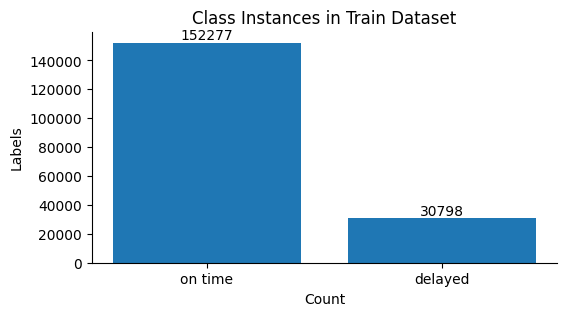


test:
 - Number of features:  11
 - Number of samples:  137306
[113851  23455]


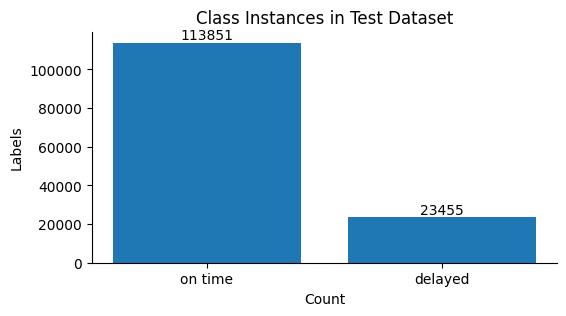


validation:
 - Number of features:  11
 - Number of samples:  137307
[113842  23465]


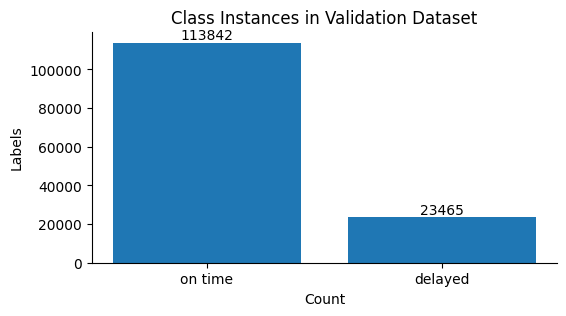

In [3]:
'''
process data for training, split into test/train/validation
'''
X = master_df.drop(columns=["ArrDel15"])
y = master_df[["ArrDel15"]]
y = y.ArrDel15.ravel() # flatten
print("# samples:", y.shape[0])

# split into train and test/validation (which is then split in next line)
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y,
                                                    test_size=0.6,
                                                    random_state=150)

# create validation and test sets each 15% of total data
X_test, X_validation, y_test, y_validation = train_test_split(X_test_val, y_test_val,
                                                    test_size=0.5,
                                                    random_state=150)
data = {"train": (X_train,y_train), "test":(X_test,y_test), "validation": (X_validation,y_validation)}

# number of classes, number of instances in each class
for each in data.keys():
    print(f"{each}:")
    print(" - Number of features: ", len(data[each][0].columns))
    print(" - Number of samples: ", len(data[each][0]))
    unique, counts = np.unique(data[each][1], return_counts=True)
    plot_frequencies(each, (unique, counts))
    print()

In [4]:
# create train numpy arrays
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
X_validation = X_validation.to_numpy()

# convert to tensors
X_train, y_train, X_test, y_test, X_validation, y_validation = map(
    torch.tensor, (X_train, y_train, X_test, y_test, X_validation, y_validation)
)

In [5]:
# create dataset and dataloader
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)
valid_ds = TensorDataset(X_validation, y_validation)
num_features=X_train.shape[1] 

using:  cpu


100%|██████████| 10/10 [00:26<00:00,  2.60s/it]

best loss:  0.25910183787345886
+---------------------------+---------+
| Hyperparameter            |   Value |
+===========================+=========+
| Best batch size:          |   64    |
+---------------------------+---------+
| Best epoch:               |   10    |
+---------------------------+---------+
| Best learning rate:       |    0.01 |
+---------------------------+---------+
| Best num nodes:           |    2    |
+---------------------------+---------+
| Best num layers:          |    1    |
+---------------------------+---------+
| Best momentum:            |    0    |
+---------------------------+---------+
| Best weight decay:        |    0    |
+---------------------------+---------+
| Best dropout probability: |    0    |
+---------------------------+---------+


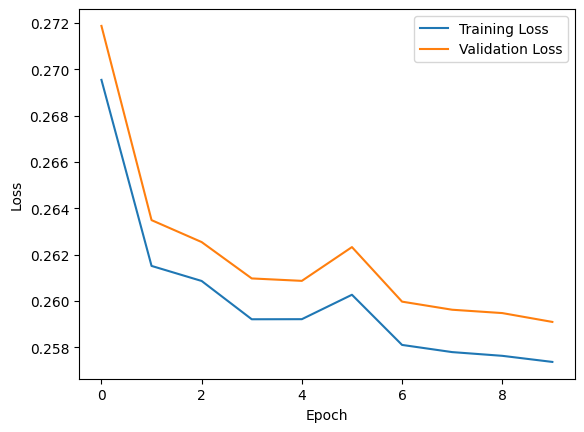

Evaluating **train** dataset:
using:  cpu


100%|██████████| 2861/2861 [00:01<00:00, 2624.50it/s]


Mean Accuracy: 92.446
Mean per-class accuracy:
  on time: 100.000%
  delayed: 55.098%
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    152277
         1.0       1.00      0.55      0.71     30798

    accuracy                           0.92    183075
   macro avg       0.96      0.78      0.83    183075
weighted avg       0.93      0.92      0.92    183075

[[152277      0]
 [ 13829  16969]]

Evaluating **test** dataset:
using:  cpu


100%|██████████| 2146/2146 [00:00<00:00, 2887.67it/s]


Mean Accuracy: 92.325
Mean per-class accuracy:
  on time: 100.000%
  delayed: 55.071%
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    113851
         1.0       1.00      0.55      0.71     23455

    accuracy                           0.92    137306
   macro avg       0.96      0.78      0.83    137306
weighted avg       0.93      0.92      0.91    137306

[[113851      0]
 [ 10538  12917]]

Evaluating **validation** dataset:
using:  cpu


100%|██████████| 2146/2146 [00:00<00:00, 2869.31it/s]


Mean Accuracy: 92.365
Mean per-class accuracy:
  on time: 100.000%
  delayed: 55.325%
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    113842
         1.0       1.00      0.55      0.71     23465

    accuracy                           0.92    137307
   macro avg       0.96      0.78      0.83    137307
weighted avg       0.93      0.92      0.91    137307

[[113842      0]
 [ 10483  12982]]



In [6]:
params = {"bs":(64,),
        "epoch":(10,),
        "learning_rate":(.01,),
        "momentum":(0,),
        "weight_decay":(0,),
        "activation_fn": nn.ReLU,
        "dropout_prob": (0,),
        "num_layers": (1,),
        "num_nodes": (2,)}
best_model_params = run_model(param_dict=params, 
                  train_ds=train_ds, 
                  test_ds=test_ds, 
                  valid_ds=valid_ds,
                  num_features=num_features
                  )

In [7]:
save_model_pkl(best_model_params)

In [8]:
model = load_model("../models/1_2_state_dict.pkl")

In [9]:
model.predict(train_ds)

using:  cpu


100%|██████████| 2861/2861 [00:01<00:00, 1640.37it/s]


(tensor([0, 0, 1,  ..., 0, 0, 0], dtype=torch.int32),
 tensor([0.0845, 0.1308, 0.9995,  ..., 0.0761, 0.1189, 0.0596]),
 tensor([0, 0, 1,  ..., 0, 0, 0], dtype=torch.int32))